In [84]:
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer

In [85]:
sns.set(style="darkgrid")

# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Set printing options to show all elements
np.set_printoptions(threshold=np.inf)

In [86]:
dataset = pd.read_csv('csvs/dataset.csv')

In [87]:
# 1. Get a brief information on the data.
dataset.columns.values[0] = 'index'

print('\nThe columns are:  ')
print(dataset.columns)

print('\nNumber of X tuples = {}'.format(dataset.shape[0]))

print('\n')
print(dataset.info())
print('\n')
print(dataset.head())


The columns are:  
Index(['index', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

Number of X tuples = 114000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 

In [88]:
# 2. Get all possible genre value
print('number of genre : {}'.format(dataset.track_genre.nunique()))
print(dataset.track_genre.unique())

number of genre : 114
['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
 'sa

In [89]:
'''
3. Begin data preprocessing
'''
# Normalize data between [0-1]
def minMax_normalization(column):
    clean_dataset[column] = (clean_dataset[column] - clean_dataset[column].min()) / (clean_dataset[column].max() - clean_dataset[column].min())
    return clean_dataset[column]    

# Drop the row where track_name = null
dataset.drop(dataset.index[dataset['track_name'].isnull()], inplace=True)   

# Operate on second set of data
clean_dataset=dataset.copy()

# Sort by popularity first, so when we drop duplicate we drop lower popularity
# Drop duplicate if track_name, duration_ms, artists and track_genre are all the same
clean_dataset.sort_values(by=['popularity'],ascending=False,inplace=True)
clean_dataset.drop_duplicates(subset=['track_name','duration_ms','artists','track_genre'],inplace=True)

# If track_name, duration_ms and artists are same, but genre is different, aggregate the genre
clean_dataset = clean_dataset.groupby(['track_name','duration_ms','artists'],as_index=False).agg({'track_genre':lambda x: ','.join(x),
                                                                                                  'index': 'first',
                                                                                                  'track_id': 'first',
                                                                                                  'popularity': 'max',
                                                                                                  'explicit': 'first',
                                                                                                  'danceability': 'first',
                                                                                                  'energy': 'first',
                                                                                                  'loudness': 'first',
                                                                                                  'speechiness': 'first',
                                                                                                  'acousticness': 'first',
                                                                                                  'instrumentalness': 'first',
                                                                                                  'liveness': 'first',
                                                                                                  'valence': 'first',
                                                                                                  'tempo': 'first,
                                                                                                  'key': 'first',
                                                                                                  'mode': 'first'})


# Drop the song where genre is sleep only, since those song target ASMR audiences
clean_dataset.drop(clean_dataset.index[clean_dataset['track_genre'] == 'sleep'], inplace=True)

# Remove row where tempo is 0
clean_dataset.drop(clean_dataset.index[clean_dataset['tempo'] == 0], inplace=True)

# Normalise popularity column
minMax_normalization('popularity')

# Binarise explicit column to 0 and 1
clean_dataset["explicit"] = clean_dataset["explicit"].astype(int)

# Rearrange the columns
clean_dataset = clean_dataset[['track_id','track_name','artists','duration_ms','popularity','track_genre','explicit','danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo', 'key', 'mode']]
clean_dataset.reset_index(inplace=True)

In [90]:
# Export the processed data to csv
clean_dataset.to_csv('csvs/clean_data.csv',index=False)

In [110]:
# Sort the popularity with more than 95 scores in descending order
clean_dataset.describe().transpose()
popular_song = clean_dataset.query('popularity>=0.95', inplace=False).sort_values('popularity',ascending=False)
print(popular_song)

       index                track_id                             track_name  \
70554  71414  3nqQXoyQOWXiESFLlDF1hG              Unholy (feat. Kim Petras)   
53343  53958  2tTmW7RDtMQtBk7m2rYeSw  Quevedo: Bzrp Music Sessions, Vol. 52   
31135  31490  4uUG5RXrOk84mYEfFvj3cK                        I'm Good (Blue)   
35988  36367  5ww2BF9slyYgNOk37BlC4u                             La Bachata   
41519  41946  6Sq7ltF9Qa7SNFBsV5Cogx                        Me Porto Bonito   
68153  68997  1IHWl5LamUGEuP4ozKQSXZ                       Tití Me Preguntó   
19067  19310  5Eax0qFko2dh7Rl2lYs3bx                                 Efecto   
29824  30175  4h9wh7iOZ0GGn8QVp4RAOB                        I Ain't Worried   
70428  71287  5IgjP7X4th6nMNDh4akUHb                    Under The Influence   
5044    5095  4LRPiXqCikLlN15c3yImP7                              As It Was   
47965  48498  3k3NWokhRRkEPhCzPmV8TW                          Ojitos Lindos   

                          artists  duration_ms  pop

In [108]:
# Sort the popularity and genre to determine the most popular genres.
# Genre is stored as an array from previous processing.
genre_popularity = clean_dataset.copy()
genre_popularity['track_genre'] = genre_popularity['track_genre'].apply(lambda x: x.split(','))
genre_popularity = genre_popularity.explode('track_genre')
print(genre_popularity.info())

<class 'pandas.core.frame.DataFrame'>
Index: 101409 entries, 0 to 82109
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             101409 non-null  int64  
 1   track_id          101409 non-null  object 
 2   track_name        101409 non-null  object 
 3   artists           101409 non-null  object 
 4   duration_ms       101409 non-null  int64  
 5   popularity        101409 non-null  float64
 6   track_genre       101409 non-null  object 
 7   explicit          101409 non-null  int32  
 8   danceability      101409 non-null  float64
 9   energy            101409 non-null  float64
 10  loudness          101409 non-null  float64
 11  speechiness       101409 non-null  float64
 12  acousticness      101409 non-null  float64
 13  instrumentalness  101409 non-null  float64
 14  liveness          101409 non-null  float64
 15  valence           101409 non-null  float64
 16  tempo             101409 n

In [93]:
# Calculate the average popularity for each genre and sorts them in descending order. 
avg_popularity_genre = genre_popularity.groupby('track_genre')['popularity'].mean()
avg_popularity_genre_sorted = avg_popularity_genre.sort_values(ascending=False)
most_popular_genres = avg_popularity_genre_sorted.head(10)

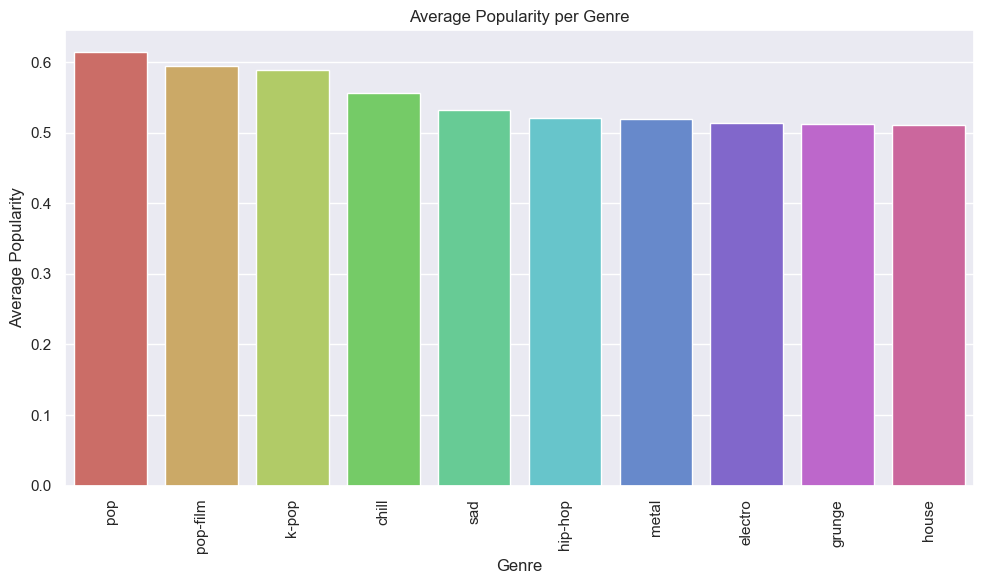

In [94]:
# Histogram showing the average popularity per genre
plt.figure(figsize=(10,6))
sns.barplot(x=most_popular_genres.index, y=most_popular_genres.values, palette="hls")
plt.title("Average Popularity per Genre")
plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

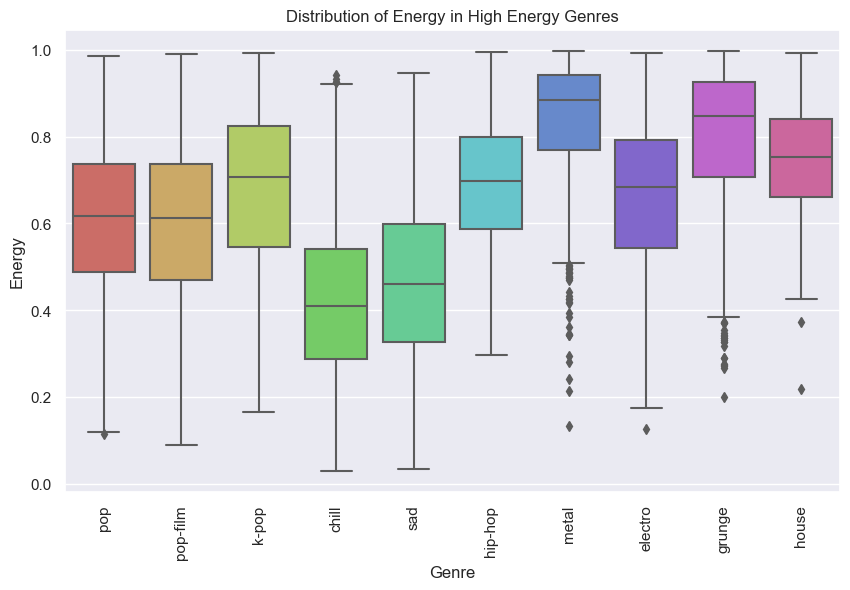

In [101]:
# Truncate genre_popularity to only include the most popular genres, and list from most popular to least popular
genre_popularity.loc[genre_popularity['track_genre'].isin(most_popular_genres.index)]

# Energy distribution in different genres 
plt.figure(figsize=(10, 6))

# Box plot or violin plot for high energy genres
sns.boxplot(x='track_genre', y='energy', data=genre_popularity[genre_popularity['track_genre'].isin(most_popular_genres.index)], palette="hls")
plt.title("Distribution of Energy in High Energy Genres")
plt.xlabel("Genre")
plt.ylabel("Energy")
plt.xticks(rotation=90)

plt.show()

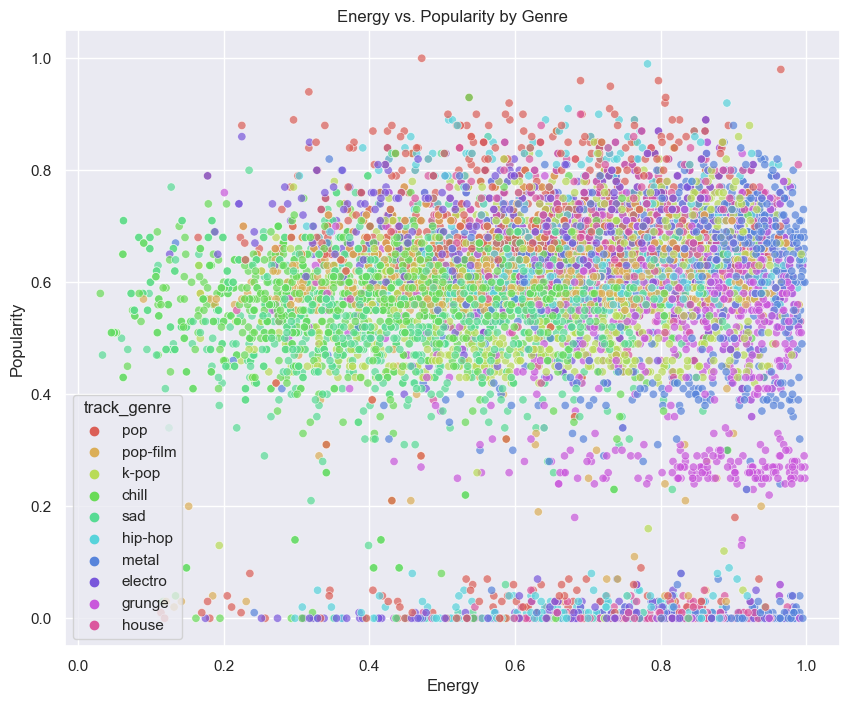

In [102]:
# Correlation between energy and popularity
plt.figure(figsize=(10, 8))
sns.scatterplot(x='energy', y='popularity', hue='track_genre', data=genre_popularity[genre_popularity['track_genre'].isin(most_popular_genres.index)], alpha=0.7, palette='hls')
plt.title("Energy vs. Popularity by Genre")
plt.xlabel("Energy")
plt.ylabel("Popularity")
plt.show()